# Домашнее задание 2: Создание и оптимизация ResNet18

## Общая цель
Поэтапная разработка кастомной ResNet18 модели для классификации Tiny ImageNet с анализом влияния различных архитектурных решений на производительность.

Датасет: Tiny ImageNet (200 классов) - выберите 10 классов самостоятельно для работы

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cpu


## Часть 1: Подготовка данных

### Создание датакласса
Реализуйте собственный класс `TinyImageNetDataset`, наследующий от `torch.utils.data.Dataset`:

- Метод `__init__`: инициализация путей к данным, загрузка списка изображений и меток
- Метод `__len__`: возврат количества примеров в датасете
- Метод `__getitem__`: загрузка и возврат одного примера (изображение + метка)

In [13]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', selected_classes=None, transform=None):
        """
        Args:
            root_dir (str): Путь к корневой директории Tiny ImageNet
            split (str): 'train', 'val' или 'test'
            selected_classes (list): Список выбранных классов (wnid)
            transform: Трансформации для изображений
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        self.selected_classes = selected_classes
        
        # Создаем маппинг класс -> индекс
        if selected_classes:
            self.class_to_idx = {cls: idx for idx, cls in enumerate(sorted(selected_classes))}
        else:
            # Если классы не указаны, используем все
            all_classes = sorted([d.name for d in (self.root_dir / 'train').iterdir() if d.is_dir()])
            self.class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
        
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        self.samples = []
        self._load_samples()
        
    def _load_samples(self):
        if self.split == 'train':
            train_dir = self.root_dir / 'train'
            for class_name in self.class_to_idx.keys():
                class_dir = train_dir / class_name / 'images'
                if class_dir.exists():
                    for img_path in class_dir.glob('*.JPEG'):
                        self.samples.append((str(img_path), self.class_to_idx[class_name]))
        
        elif self.split in ['val', 'test']:
            val_dir = self.root_dir / 'val'
            annotations_file = val_dir / 'val_annotations.txt'
            if annotations_file.exists():
                with open(annotations_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split('\t')
                        img_name = parts[0]
                        class_name = parts[1]
                        
                        if class_name in self.class_to_idx:
                            img_path = val_dir / 'images' / img_name
                            if img_path.exists():
                                self.samples.append((str(img_path), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [14]:
TINY_IMAGENET_PATH = './tiny-imagenet-200'

SELECTED_CLASSES = [
    'n01443537',  # goldfish
    'n01629819',  # European fire salamander
    'n01641577',  # bullfrog
    'n01644900',  # tailed frog
    'n01698640',  # American alligator
    'n01742172',  # boa constrictor
    'n01768244',  # trilobite
    'n01770393',  # scorpion
    'n01774384',  # black widow spider
    'n01774750',  # tarantula
]

NUM_CLASSES = len(SELECTED_CLASSES)

# Трансформации для обучающего набора с аугментацией
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(64, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Трансформации для валидационного набора без аугментации
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PATH,
    split='train',
    selected_classes=SELECTED_CLASSES,
    transform=train_transform
)

val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PATH,
    split='val',
    selected_classes=SELECTED_CLASSES,
    transform=val_transform
)

BATCH_SIZE = 64
NUM_WORKERS = 0

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Train batches: {len(train_loader)}')
print(f'Validation batches: {len(val_loader)}')

sample_batch, sample_labels = next(iter(train_loader))
print(f'Sample batch shape: {sample_batch.shape}')
print(f'Sample labels shape: {sample_labels.shape}')

Train samples: 5000
Validation samples: 500
Batch size: 64
Train batches: 79
Validation batches: 8
Sample batch shape: torch.Size([64, 3, 64, 64])
Sample labels shape: torch.Size([64])


## Часть 2: Базовая архитектура ResNet18

### 2.1 Реализация Basic Block

Создайте базовый residual блок со следующей структурой:

```
Input
  ↓
Conv2d(kernel_size=3, padding=1, stride=stride)
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
Conv2d(kernel_size=3, padding=1, stride=1)
  ↓
BatchNorm2d
  ↓
  + ← Skip Connection (с возможностью downsample)
  ↓
ReLU
  ↓
Output
```
**Важно:**

- Если входные и выходные размерности не совпадают, используйте skip connection с Conv2d(1x1) + BatchNorm2d
- Первый residual блок может иметь stride=2 для уменьшения пространственного размера

In [15]:
class BasicBlock(nn.Module):
    """
    Базовый residual блок для ResNet18.
    
    Структура:
    Input -> Conv3x3 -> BN -> Activation -> Conv3x3 -> BN -> (+skip) -> Activation -> Output
    
    Skip connection может включать downsample (Conv1x1 + BN) если размерности не совпадают.
    """
    
    def __init__(self, in_channels, out_channels, stride=1, activation=nn.ReLU):
        """
        Args:
            in_channels: Количество входных каналов
            out_channels: Количество выходных каналов
            stride: Шаг свертки (1 или 2 для downsampling)
            activation: Функция активации (по умолчанию ReLU)
        """
        super(BasicBlock, self).__init__()
        
        # Первая свертка (может иметь stride > 1 для уменьшения размера)
        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Вторая свертка (всегда stride=1)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Функция активации
        self.activation = activation if activation is nn.GELU else activation(inplace=True)
        
        # Skip connection (downsample если размерности не совпадают)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Skip connection
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Residual connection
        out += identity
        out = self.activation(out)
        
        return out

# Тестируем BasicBlock
test_block = BasicBlock(64, 128, stride=2)
test_input = torch.randn(1, 64, 32, 32)
test_output = test_block(test_input)
print(f'BasicBlock test:')
print(f'Input shape: {test_input.shape}')
print(f'Output shape: {test_output.shape}')

BasicBlock test:
Input shape: torch.Size([1, 64, 32, 32])
Output shape: torch.Size([1, 128, 16, 16])


### 2.2 Реализация ResNet18

Создайте архитектуру ResNet18 со следующей структурой:
```
Input (3, 64, 64)
  ↓
Conv2d(3→64, kernel_size=7, stride=2, padding=3)  # или 3x3, stride=1 для Tiny ImageNet
  ↓
BatchNorm2d
  ↓
ReLU
  ↓
MaxPool2d(kernel_size=3, stride=2, padding=1)  # опционально для Tiny ImageNet
  ↓
Layer1: 2x Basic Block (64 channels)
  ↓
Layer2: 2x Basic Block (128 channels, stride=2 в первом блоке)
  ↓
Layer3: 2x Basic Block (256 channels, stride=2 в первом блоке)
  ↓
Layer4: 2x Basic Block (512 channels, stride=2 в первом блоке)  # ОПЦИОНАЛЬНО
  ↓
AdaptiveAvgPool2d(output_size=(1, 1))
  ↓
Flatten
  ↓
Linear(512 → 10)  # 10 классов
  ↓
Output
```

### 2.3. Ограничения для базовой модели:
- Общее количество параметров: не более 5 миллионов
- Максимальное количество каналов: до 512

In [16]:
class ResNet18(nn.Module):
    """
    Кастомная реализация ResNet18 для Tiny ImageNet.
    
    Поддерживает различные конфигурации:
    - Количество каналов в каждом слое
    - Количество residual блоков в каждом слое
    - Различные функции активации
    """
    
    def __init__(self, num_classes=10, channels=[64, 128, 256, 512],
                 num_blocks=[2, 2, 2, 2], activation=nn.ReLU, use_maxpool=False):
        """
        Args:
            num_classes: Количество классов для классификации
            channels: Список количества каналов для каждого слоя
            num_blocks: Список количества блоков в каждом слое
            activation: Функция активации (nn.ReLU, nn.LeakyReLU, nn.ELU, nn.GELU)
            use_maxpool: Использовать ли MaxPool после первой свертки (для больших изображений)
        """
        super(ResNet18, self).__init__()
        
        self.in_channels = channels[0]
        self.activation = activation
        
        # Начальная свертка (адаптирована для Tiny ImageNet 64x64)
        # Используем 3x3 вместо 7x7 и stride=1 вместо stride=2
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.act1 = activation if activation is nn.GELU else activation(inplace=True)
        
        # Опциональный MaxPool (обычно не используется для Tiny ImageNet)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) if use_maxpool else None
        
        # Создаем residual слои
        self.layers = nn.ModuleList()
        for i, (out_channels, num_block) in enumerate(zip(channels, num_blocks)):
            # Первый слой без downsampling, остальные с stride=2
            stride = 2 if i > 0 else 1
            layer = self._make_layer(out_channels, num_block, stride)
            self.layers.append(layer)
        
        # Global Average Pooling и классификатор
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[-1], num_classes)
        
        # Инициализация весов
        self._initialize_weights()
    
    def _make_layer(self, out_channels, num_blocks, stride):
        """
        Создает слой из нескольких residual блоков.
        
        Args:
            out_channels: Количество выходных каналов
            num_blocks: Количество блоков в слое
            stride: Шаг для первого блока (для downsampling)
            
        Returns:
            Sequential слой из residual блоков
        """
        layers = []
        
        # Первый блок может иметь stride > 1 для downsampling
        layers.append(BasicBlock(self.in_channels, out_channels, stride, self.activation))
        self.in_channels = out_channels
        
        # Остальные блоки с stride=1
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, stride=1, activation=self.activation))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        """Инициализация весов сети (Kaiming initialization)"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Начальная свертка
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        if self.maxpool:
            x = self.maxpool(x)
        
        # Residual слои
        for layer in self.layers:
            x = layer(x)
        
        # Global pooling и классификация
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Тестируем базовую модель
baseline_model = ResNet18(
    num_classes=NUM_CLASSES,
    channels=[64, 128, 256, 512],
    num_blocks=[2, 2, 2, 2],
    activation=nn.ReLU
)

# Тестируем forward pass
test_input = torch.randn(2, 3, 64, 64)
test_output = baseline_model(test_input)

print(f'\nBaseline ResNet18 Architecture:')
print(f'Input shape: {test_input.shape}')
print(f'Output shape: {test_output.shape}')
print(f'Total parameters: {count_parameters(baseline_model):,}')
print(f'Parameters in millions: {count_parameters(baseline_model)}M')
print(f'\nModel structure:')
print(baseline_model)


Baseline ResNet18 Architecture:
Input shape: torch.Size([2, 3, 64, 64])
Output shape: torch.Size([2, 10])
Total parameters: 11,173,962
Parameters in millions: 11173962M

Model structure:
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (layers): ModuleList(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

### 2.4. Скрипт обучения
Реализуйте цикл обучения с следующими компонентами:

**Оптимизатор:**

- Adam или SGD
- Learning rate: 0.001

**Loss function:**

- CrossEntropyLoss

**Метрики:**

- Accuracy для train/validation
- Loss для train/validation

**Обучение:**

- Количество эпох: 20-30
- Логирование метрик на каждой эпохе

In [17]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': running_loss / total,
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc='Evaluating', leave=False):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_state = None
    
    print(f'Starting training for {num_epochs} epochs...')
    
    for epoch in range(num_epochs):        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Best Val Acc: {best_val_acc:.2f}%')

    print(f'Training completed! Best Val Acc: {best_val_acc:.2f}%')
    
    model.load_state_dict(best_model_state)
    
    return model, history, best_val_acc

### 2.5: Визуализация базовых результатов
После обучения базовой модели создайте:

1. **График Accuracy:**

- X: эпохи
- Y: accuracy
- Две линии: train и validation
2. **График Loss:**

- X: эпохи
- Y: loss
- Две линии: train и validation
3. **Информация о модели:**

- Общее количество параметров
- Архитектура (выведите через print(model))

In [18]:
def plot_training_history(history, title='Training History'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(history['train_acc']) + 1)
    
    ax1.plot(epochs, history['train_acc'], 'b-o', label='Train Accuracy', linewidth=2, markersize=6)
    ax1.plot(epochs, history['val_acc'], 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title(f'{title} - Accuracy', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(1, len(epochs))
    
    ax2.plot(epochs, history['train_loss'], 'b-o', label='Train Loss', linewidth=2, markersize=6)
    ax2.plot(epochs, history['val_loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title(f'{title} - Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(1, len(epochs))
    
    plt.tight_layout()
    plt.show()

def plot_multiple_histories(histories, labels, metric='val_acc', title='Comparison'):
    plt.figure(figsize=(12, 6))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(histories)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
    
    for i, (history, label) in enumerate(zip(histories, labels)):
        epochs = range(1, len(history[metric]) + 1)
        plt.plot(epochs, history[metric], 
                marker=markers[i % len(markers)], 
                label=label, 
                linewidth=2, 
                markersize=6,
                color=colors[i])
    
    plt.xlabel('Epoch', fontsize=12)
    
    if 'acc' in metric:
        plt.ylabel('Accuracy (%)', fontsize=12)
        metric_name = 'Accuracy'
    else:
        plt.ylabel('Loss', fontsize=12)
        metric_name = 'Loss'
    
    split = 'Validation' if 'val' in metric else 'Train'
    plt.title(f'{title} - {split} {metric_name}', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### 2.5 Обучение базовой модели

In [19]:
BASELINE_CHANNELS = [64, 128, 256]
BASELINE_NUM_BLOCKS = [2, 2, 2, 2]

baseline_model = ResNet18(
    num_classes=NUM_CLASSES,
    channels=BASELINE_CHANNELS,
    num_blocks=BASELINE_NUM_BLOCKS,
    activation=nn.ReLU
)

print(f'Model Configuration:')
print(f'Channels: {BASELINE_CHANNELS}')
print(f'Blocks per layer: {BASELINE_NUM_BLOCKS}')
print(f'Activation: ReLU')
print(f'Total parameters: {count_parameters(baseline_model):,}')

baseline_model, baseline_history, baseline_best_acc = train_model(
    baseline_model, 
    train_loader, 
    val_loader, 
    num_epochs=20, 
    lr=0.001, 
    device=device
)

plot_training_history(baseline_history, 'Baseline ResNet18')

print(f'Best Validation Accuracy: {baseline_best_acc:.2f}%')
print(f'Final Train Accuracy: {baseline_history["train_acc"][-1]:.2f}%')
print(f'Final Val Accuracy: {baseline_history["val_acc"][-1]:.2f}%')
print(f'Total Parameters: {count_parameters(baseline_model)}M')

Model Configuration:
Channels: [64, 128, 256]
Blocks per layer: [2, 2, 2, 2]
Activation: ReLU
Total parameters: 2,777,674
Starting training for 20 epochs...


KeyboardInterrupt: 

## Часть 3: Поэтапная оптимизация модели

### 3.1 Оптимизация количества каналов
**Цель:** Изучение влияния количества каналов на производительность.

**Эксперимент:**

- Создайте 2 варианта модели:
    - Вариант A: 32 → 64 → 128 → 256 каналов
    - Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)
- Обучите обе модели с теми же гиперпараметрами
- Сравните:
    - Количество параметров
    - Validation accuracy

**Результат:**

- Таблица сравнения
- Графики accuracy и loss для обоих вариантов
- Вывод: какая конфигурация лучше?

Вариант A: 32 → 64 → 128 → 256 каналов
Parameters: 2797610
Starting training for 20 epochs...


Epoch 1/20 | Train Loss: 2.0510 | Train Acc: 25.58% | Val Loss: 2.0373 | Val Acc: 25.00% | Best Val Acc: 25.00%


Epoch 2/20 | Train Loss: 1.9059 | Train Acc: 31.06% | Val Loss: 1.9579 | Val Acc: 32.60% | Best Val Acc: 32.60%


Epoch 3/20 | Train Loss: 1.7923 | Train Acc: 35.48% | Val Loss: 3.0216 | Val Acc: 27.60% | Best Val Acc: 32.60%


Epoch 4/20 | Train Loss: 1.7001 | Train Acc: 38.08% | Val Loss: 2.1903 | Val Acc: 33.00% | Best Val Acc: 33.00%


Epoch 5/20 | Train Loss: 1.6470 | Train Acc: 42.24% | Val Loss: 1.6856 | Val Acc: 39.60% | Best Val Acc: 39.60%


Epoch 6/20 | Train Loss: 1.5626 | Train Acc: 45.80% | Val Loss: 1.5992 | Val Acc: 43.40% | Best Val Acc: 43.40%


Epoch 7/20 | Train Loss: 1.4998 | Train Acc: 46.82% | Val Loss: 1.6132 | Val Acc: 46.20% | Best Val Acc: 46.20%


Epoch 8/20 | Train Loss: 1.4075 | Train Acc: 51.02% | Val Loss: 1.6091 | Val Acc: 43.80% | Best Val Acc: 46.20%


Epoch 9/20 | Train Loss: 1.3869 | Train Acc: 51.92% | Val Loss: 1.4870 | Val Acc: 49.80% | Best Val Acc: 49.80%


Epoch 10/20 | Train Loss: 1.3302 | Train Acc: 53.92% | Val Loss: 1.8333 | Val Acc: 42.40% | Best Val Acc: 49.80%


Epoch 11/20 | Train Loss: 1.2739 | Train Acc: 55.26% | Val Loss: 1.8105 | Val Acc: 43.60% | Best Val Acc: 49.80%


Epoch 12/20 | Train Loss: 1.2571 | Train Acc: 56.88% | Val Loss: 1.3977 | Val Acc: 50.00% | Best Val Acc: 50.00%


Epoch 13/20 | Train Loss: 1.1994 | Train Acc: 57.98% | Val Loss: 1.5584 | Val Acc: 50.20% | Best Val Acc: 50.20%


Epoch 14/20 | Train Loss: 1.1887 | Train Acc: 58.84% | Val Loss: 1.3653 | Val Acc: 54.20% | Best Val Acc: 54.20%


Epoch 15/20 | Train Loss: 1.1625 | Train Acc: 60.34% | Val Loss: 1.3720 | Val Acc: 54.80% | Best Val Acc: 54.80%


Epoch 16/20 | Train Loss: 1.1346 | Train Acc: 60.56% | Val Loss: 1.8345 | Val Acc: 49.00% | Best Val Acc: 54.80%


Epoch 17/20 | Train Loss: 1.0843 | Train Acc: 62.90% | Val Loss: 1.3435 | Val Acc: 55.80% | Best Val Acc: 55.80%


Epoch 18/20 | Train Loss: 1.0899 | Train Acc: 62.52% | Val Loss: 1.2728 | Val Acc: 55.40% | Best Val Acc: 55.80%


Epoch 19/20 | Train Loss: 1.0433 | Train Acc: 63.62% | Val Loss: 1.2493 | Val Acc: 59.60% | Best Val Acc: 59.60%


Epoch 20/20 | Train Loss: 1.0281 | Train Acc: 64.14% | Val Loss: 1.5261 | Val Acc: 52.80% | Best Val Acc: 59.60%
Training completed! Best Val Acc: 59.60%
Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)
Parameters: 2777674
Starting training for 20 epochs...


Epoch 1/20 | Train Loss: 2.0970 | Train Acc: 24.24% | Val Loss: 2.6436 | Val Acc: 22.20% | Best Val Acc: 22.20%


Epoch 2/20 | Train Loss: 1.9782 | Train Acc: 28.46% | Val Loss: 1.9575 | Val Acc: 26.40% | Best Val Acc: 26.40%


Epoch 3/20 | Train Loss: 1.8923 | Train Acc: 31.42% | Val Loss: 2.0468 | Val Acc: 29.40% | Best Val Acc: 29.40%


Epoch 4/20 | Train Loss: 1.8125 | Train Acc: 35.54% | Val Loss: 1.8334 | Val Acc: 37.20% | Best Val Acc: 37.20%


Epoch 5/20 | Train Loss: 1.7348 | Train Acc: 38.86% | Val Loss: 1.7933 | Val Acc: 39.00% | Best Val Acc: 39.00%


Epoch 6/20 | Train Loss: 1.6942 | Train Acc: 40.74% | Val Loss: 1.8922 | Val Acc: 35.40% | Best Val Acc: 39.00%


Epoch 7/20 | Train Loss: 1.6523 | Train Acc: 42.68% | Val Loss: 1.6542 | Val Acc: 43.20% | Best Val Acc: 43.20%


Epoch 8/20 | Train Loss: 1.5675 | Train Acc: 44.98% | Val Loss: 1.7645 | Val Acc: 42.80% | Best Val Acc: 43.20%


Epoch 9/20 | Train Loss: 1.5534 | Train Acc: 45.94% | Val Loss: 2.1435 | Val Acc: 39.60% | Best Val Acc: 43.20%


Epoch 10/20 | Train Loss: 1.5246 | Train Acc: 47.36% | Val Loss: 1.4940 | Val Acc: 48.60% | Best Val Acc: 48.60%


Epoch 11/20 | Train Loss: 1.4612 | Train Acc: 49.14% | Val Loss: 1.6410 | Val Acc: 44.00% | Best Val Acc: 48.60%


Epoch 12/20 | Train Loss: 1.4200 | Train Acc: 51.10% | Val Loss: 1.6244 | Val Acc: 46.20% | Best Val Acc: 48.60%


Epoch 13/20 | Train Loss: 1.3929 | Train Acc: 52.50% | Val Loss: 1.4824 | Val Acc: 48.80% | Best Val Acc: 48.80%


Epoch 14/20 | Train Loss: 1.3602 | Train Acc: 54.00% | Val Loss: 1.5103 | Val Acc: 50.40% | Best Val Acc: 50.40%


Epoch 15/20 | Train Loss: 1.2991 | Train Acc: 55.26% | Val Loss: 1.8199 | Val Acc: 45.00% | Best Val Acc: 50.40%


Epoch 16/20 | Train Loss: 1.2854 | Train Acc: 55.64% | Val Loss: 1.4493 | Val Acc: 51.60% | Best Val Acc: 51.60%


Epoch 17/20 | Train Loss: 1.2474 | Train Acc: 58.54% | Val Loss: 1.7142 | Val Acc: 47.60% | Best Val Acc: 51.60%


Epoch 18/20 | Train Loss: 1.2436 | Train Acc: 57.76% | Val Loss: 1.6900 | Val Acc: 48.00% | Best Val Acc: 51.60%


Epoch 19/20 | Train Loss: 1.2057 | Train Acc: 58.38% | Val Loss: 1.4682 | Val Acc: 51.40% | Best Val Acc: 51.60%


Epoch 20/20 | Train Loss: 1.1614 | Train Acc: 60.24% | Val Loss: 1.7936 | Val Acc: 42.80% | Best Val Acc: 51.60%
Training completed! Best Val Acc: 51.60%

            Variant Parameters Best Val Acc (%) Final Train Acc (%)
A: [32,64,128,256]    2797610            59.60               64.14
   B: [64,128,256]    2777674            51.60               60.24


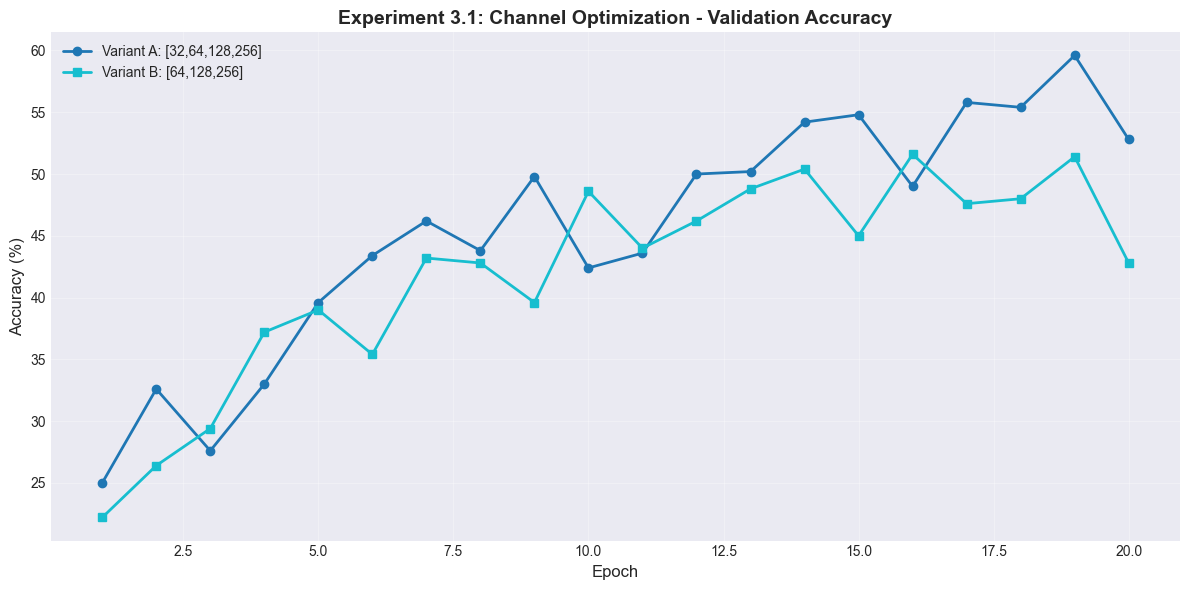

Лучшая конфигурация: вариант A с каналами [32, 64, 128, 256]
Лучшая Val Accuracy: 59.60%


In [ ]:
print('Вариант A: 32 → 64 → 128 → 256 каналов')

model_3_1_a = ResNet18(
    num_classes=NUM_CLASSES,
    channels=[32, 64, 128, 256],
    num_blocks=[2, 2, 2, 2],
    activation=nn.ReLU
)

print(f'Parameters: {count_parameters(model_3_1_a)}')

model_3_1_a, history_3_1_a, best_acc_3_1_a = train_model(
    model_3_1_a, train_loader, val_loader, num_epochs=20, lr=0.001, device=device
)

print('Вариант B: 64 → 128 → 256 каналов (без 4-го слоя)')

model_3_1_b = ResNet18(
    num_classes=NUM_CLASSES,
    channels=[64, 128, 256],
    num_blocks=[2, 2, 2],
    activation=nn.ReLU
)

print(f'Parameters: {count_parameters(model_3_1_b)}')

model_3_1_b, history_3_1_b, best_acc_3_1_b = train_model(
    model_3_1_b, train_loader, val_loader, num_epochs=20, lr=0.001, device=device
)

results_3_1 = pd.DataFrame({
    'Variant': ['A: [32,64,128,256]', 'B: [64,128,256]'],
    'Parameters': [
        f'{count_parameters(model_3_1_a)}',
        f'{count_parameters(model_3_1_b)}'
    ],
    'Best Val Acc (%)': [f'{best_acc_3_1_a:.2f}', f'{best_acc_3_1_b:.2f}'],
    'Final Train Acc (%)': [
        f'{history_3_1_a["train_acc"][-1]:.2f}',
        f'{history_3_1_b["train_acc"][-1]:.2f}'
    ]
})

print('\n', results_3_1.to_string(index=False))

plot_multiple_histories(
    [history_3_1_a, history_3_1_b],
    ['Variant A: [32,64,128,256]', 'Variant B: [64,128,256]'],
    metric='val_acc',
    title='Experiment 3.1: Channel Optimization'
)

best_variant = 'A' if best_acc_3_1_a > best_acc_3_1_b else 'B'
best_channels = [32, 64, 128, 256] if best_variant == 'A' else [64, 128, 256]

print(f'Лучшая конфигурация: вариант {best_variant} с каналами {best_channels}')
print(f'Лучшая Val Accuracy: {max(best_acc_3_1_a, best_acc_3_1_b):.2f}%')

best_channels_3_1 = best_channels

### 3.2 Эксперименты с количеством residual блоков

**Цель:** Изучение влияния глубины сети (количества residual блоков) на производительность.

**Эксперимент:**

- Используйте лучшую конфигурацию каналов из Этапа 3.1
- Создайте 3 варианта модели с разным количеством блоков в каждом слое:
    - Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)
    - Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)
    - Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)
- Обучите все три модели с одинаковыми гиперпараметрами

**Архитектура вариантов:**

```
Вариант A (4 блока):  Layer1[1 блок] → Layer2[1 блок] → Layer3[1 блок] → Layer4[1 блок]
Вариант B (8 блоков): Layer1[2 блока] → Layer2[2 блока] → Layer3[2 блока] → Layer4[2 блока]
Вариант C (12 блоков): Layer1[3 блока] → Layer2[3 блока] → Layer3[3 блока] → Layer4[3 блока]
```

**Результат:**

- Сравните:
    - Количество параметров
    - Validation accuracy
    - Скорость сходимости (на каких эпохах модель достигает лучших результатов)
- Графики accuracy для всех трех вариантов на одном графике
- Анализ: какая глубина оптимальна? Есть ли переобучение у более глубоких моделей?
- Вывод: какое количество блоков работает лучше?

Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)
Parameters: 1228970
Starting training for 20 epochs...


Epoch 1/20 | Train Loss: 2.0752 | Train Acc: 24.48% | Val Loss: 1.9508 | Val Acc: 28.20% | Best Val Acc: 28.20%


Epoch 2/20 | Train Loss: 1.8749 | Train Acc: 33.64% | Val Loss: 1.9708 | Val Acc: 33.00% | Best Val Acc: 33.00%


Epoch 3/20 | Train Loss: 1.7518 | Train Acc: 38.46% | Val Loss: 1.7205 | Val Acc: 39.80% | Best Val Acc: 39.80%


Epoch 4/20 | Train Loss: 1.6639 | Train Acc: 40.96% | Val Loss: 1.8171 | Val Acc: 39.40% | Best Val Acc: 39.80%


Epoch 5/20 | Train Loss: 1.5953 | Train Acc: 44.02% | Val Loss: 1.6943 | Val Acc: 42.00% | Best Val Acc: 42.00%


Epoch 6/20 | Train Loss: 1.5227 | Train Acc: 47.18% | Val Loss: 1.4996 | Val Acc: 50.20% | Best Val Acc: 50.20%


Epoch 7/20 | Train Loss: 1.4807 | Train Acc: 48.82% | Val Loss: 1.5488 | Val Acc: 48.80% | Best Val Acc: 50.20%


Epoch 8/20 | Train Loss: 1.3961 | Train Acc: 51.38% | Val Loss: 1.4297 | Val Acc: 49.60% | Best Val Acc: 50.20%


Epoch 9/20 | Train Loss: 1.3614 | Train Acc: 53.14% | Val Loss: 1.6380 | Val Acc: 48.00% | Best Val Acc: 50.20%


Epoch 10/20 | Train Loss: 1.3259 | Train Acc: 55.22% | Val Loss: 1.8329 | Val Acc: 40.60% | Best Val Acc: 50.20%


Epoch 11/20 | Train Loss: 1.2348 | Train Acc: 57.48% | Val Loss: 1.3836 | Val Acc: 54.00% | Best Val Acc: 54.00%


Epoch 12/20 | Train Loss: 1.1910 | Train Acc: 59.00% | Val Loss: 1.5128 | Val Acc: 52.20% | Best Val Acc: 54.00%


Epoch 13/20 | Train Loss: 1.1458 | Train Acc: 61.08% | Val Loss: 1.3259 | Val Acc: 54.20% | Best Val Acc: 54.20%


Epoch 14/20 | Train Loss: 1.1372 | Train Acc: 61.34% | Val Loss: 1.6997 | Val Acc: 49.00% | Best Val Acc: 54.20%


Epoch 15/20 | Train Loss: 1.1354 | Train Acc: 60.96% | Val Loss: 1.3067 | Val Acc: 55.60% | Best Val Acc: 55.60%


Epoch 16/20 | Train Loss: 1.0922 | Train Acc: 62.72% | Val Loss: 1.2442 | Val Acc: 56.60% | Best Val Acc: 56.60%


Epoch 17/20 | Train Loss: 1.0812 | Train Acc: 62.70% | Val Loss: 1.4684 | Val Acc: 54.20% | Best Val Acc: 56.60%


Epoch 18/20 | Train Loss: 1.0553 | Train Acc: 64.06% | Val Loss: 1.2832 | Val Acc: 58.00% | Best Val Acc: 58.00%


Epoch 19/20 | Train Loss: 1.0726 | Train Acc: 63.66% | Val Loss: 1.2535 | Val Acc: 58.00% | Best Val Acc: 58.00%


Epoch 20/20 | Train Loss: 1.0032 | Train Acc: 65.80% | Val Loss: 1.2329 | Val Acc: 61.40% | Best Val Acc: 61.40%
Training completed! Best Val Acc: 61.40%
Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)
Parameters: 2797610
Starting training for 20 epochs...


Epoch 1/20 | Train Loss: 2.0477 | Train Acc: 25.36% | Val Loss: 1.9662 | Val Acc: 25.20% | Best Val Acc: 25.20%


Epoch 2/20 | Train Loss: 1.8948 | Train Acc: 31.46% | Val Loss: 1.9139 | Val Acc: 32.80% | Best Val Acc: 32.80%


Epoch 3/20 | Train Loss: 1.7689 | Train Acc: 36.40% | Val Loss: 1.7030 | Val Acc: 41.60% | Best Val Acc: 41.60%


Epoch 4/20 | Train Loss: 1.6910 | Train Acc: 40.10% | Val Loss: 1.6508 | Val Acc: 42.40% | Best Val Acc: 42.40%


Epoch 5/20 | Train Loss: 1.6367 | Train Acc: 41.42% | Val Loss: 1.6228 | Val Acc: 41.40% | Best Val Acc: 42.40%


Epoch 6/20 | Train Loss: 1.5367 | Train Acc: 45.06% | Val Loss: 1.6152 | Val Acc: 42.40% | Best Val Acc: 42.40%


Epoch 7/20 | Train Loss: 1.5017 | Train Acc: 47.02% | Val Loss: 1.5033 | Val Acc: 46.00% | Best Val Acc: 46.00%


Epoch 8/20 | Train Loss: 1.4222 | Train Acc: 49.74% | Val Loss: 1.9022 | Val Acc: 39.20% | Best Val Acc: 46.00%


Epoch 9/20 | Train Loss: 1.3872 | Train Acc: 51.56% | Val Loss: 1.4286 | Val Acc: 47.80% | Best Val Acc: 47.80%


Epoch 10/20 | Train Loss: 1.3213 | Train Acc: 53.94% | Val Loss: 1.3653 | Val Acc: 53.00% | Best Val Acc: 53.00%


Epoch 11/20 | Train Loss: 1.2966 | Train Acc: 54.68% | Val Loss: 1.7049 | Val Acc: 45.00% | Best Val Acc: 53.00%


Epoch 12/20 | Train Loss: 1.2677 | Train Acc: 55.74% | Val Loss: 2.3543 | Val Acc: 41.60% | Best Val Acc: 53.00%


Epoch 13/20 | Train Loss: 1.2457 | Train Acc: 56.94% | Val Loss: 1.3936 | Val Acc: 52.40% | Best Val Acc: 53.00%


Epoch 14/20 | Train Loss: 1.2156 | Train Acc: 57.62% | Val Loss: 1.4978 | Val Acc: 48.40% | Best Val Acc: 53.00%


Epoch 15/20 | Train Loss: 1.0801 | Train Acc: 62.46% | Val Loss: 1.2348 | Val Acc: 59.00% | Best Val Acc: 59.00%


Epoch 16/20 | Train Loss: 1.0771 | Train Acc: 63.08% | Val Loss: 1.1871 | Val Acc: 57.40% | Best Val Acc: 59.00%


Epoch 17/20 | Train Loss: 1.0318 | Train Acc: 64.62% | Val Loss: 1.3713 | Val Acc: 54.60% | Best Val Acc: 59.00%


Epoch 18/20 | Train Loss: 0.9967 | Train Acc: 65.90% | Val Loss: 1.3901 | Val Acc: 57.00% | Best Val Acc: 59.00%


Epoch 19/20 | Train Loss: 0.9965 | Train Acc: 65.08% | Val Loss: 1.2588 | Val Acc: 58.60% | Best Val Acc: 59.00%


Epoch 20/20 | Train Loss: 0.9243 | Train Acc: 68.22% | Val Loss: 1.0822 | Val Acc: 63.60% | Best Val Acc: 63.60%
Training completed! Best Val Acc: 63.60%
Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)
Parameters: 4366250
Starting training for 20 epochs...


Epoch 1/20 | Train Loss: 2.1008 | Train Acc: 22.92% | Val Loss: 2.0412 | Val Acc: 26.00% | Best Val Acc: 26.00%


Epoch 2/20 | Train Loss: 1.9383 | Train Acc: 28.98% | Val Loss: 2.0165 | Val Acc: 25.00% | Best Val Acc: 26.00%


Epoch 3/20 | Train Loss: 1.8775 | Train Acc: 32.42% | Val Loss: 3.2938 | Val Acc: 21.40% | Best Val Acc: 26.00%


Epoch 4/20 | Train Loss: 1.7819 | Train Acc: 36.20% | Val Loss: 1.9309 | Val Acc: 30.60% | Best Val Acc: 30.60%


Epoch 5/20 | Train Loss: 1.7223 | Train Acc: 38.72% | Val Loss: 1.7950 | Val Acc: 35.80% | Best Val Acc: 35.80%


Epoch 6/20 | Train Loss: 1.6455 | Train Acc: 41.44% | Val Loss: 1.8088 | Val Acc: 33.00% | Best Val Acc: 35.80%


Epoch 7/20 | Train Loss: 1.5921 | Train Acc: 43.60% | Val Loss: 1.6237 | Val Acc: 43.60% | Best Val Acc: 43.60%


Epoch 8/20 | Train Loss: 1.5453 | Train Acc: 45.10% | Val Loss: 2.0955 | Val Acc: 37.60% | Best Val Acc: 43.60%


Epoch 9/20 | Train Loss: 1.4729 | Train Acc: 48.10% | Val Loss: 1.4851 | Val Acc: 50.00% | Best Val Acc: 50.00%


Epoch 10/20 | Train Loss: 1.4445 | Train Acc: 49.58% | Val Loss: 1.7702 | Val Acc: 43.80% | Best Val Acc: 50.00%


Epoch 11/20 | Train Loss: 1.4093 | Train Acc: 50.76% | Val Loss: 1.4687 | Val Acc: 48.80% | Best Val Acc: 50.00%


Epoch 12/20 | Train Loss: 1.3326 | Train Acc: 53.34% | Val Loss: 1.5577 | Val Acc: 46.00% | Best Val Acc: 50.00%


Epoch 13/20 | Train Loss: 1.3396 | Train Acc: 53.10% | Val Loss: 1.5813 | Val Acc: 46.20% | Best Val Acc: 50.00%


Epoch 14/20 | Train Loss: 1.2033 | Train Acc: 58.58% | Val Loss: 1.5245 | Val Acc: 49.60% | Best Val Acc: 50.00%


Epoch 15/20 | Train Loss: 1.1710 | Train Acc: 59.52% | Val Loss: 1.2460 | Val Acc: 57.60% | Best Val Acc: 57.60%


Epoch 16/20 | Train Loss: 1.1484 | Train Acc: 60.50% | Val Loss: 1.2948 | Val Acc: 55.00% | Best Val Acc: 57.60%


Epoch 17/20 | Train Loss: 1.1255 | Train Acc: 61.54% | Val Loss: 1.3741 | Val Acc: 55.20% | Best Val Acc: 57.60%


Epoch 18/20 | Train Loss: 1.1039 | Train Acc: 62.38% | Val Loss: 1.2490 | Val Acc: 59.60% | Best Val Acc: 59.60%


Epoch 19/20 | Train Loss: 1.0744 | Train Acc: 62.94% | Val Loss: 1.2561 | Val Acc: 55.60% | Best Val Acc: 59.60%


Epoch 20/20 | Train Loss: 1.0791 | Train Acc: 62.34% | Val Loss: 1.2733 | Val Acc: 55.40% | Best Val Acc: 59.60%
Training completed! Best Val Acc: 59.60%

      Variant  Total Blocks Parameters Best Val Acc (%) Final Train Acc (%)
A: [1,1,1,1]             4    1228970            61.40               65.80
B: [2,2,2,2]             8    2797610            63.60               68.22
C: [3,3,3,3]            12    4366250            59.60               62.34


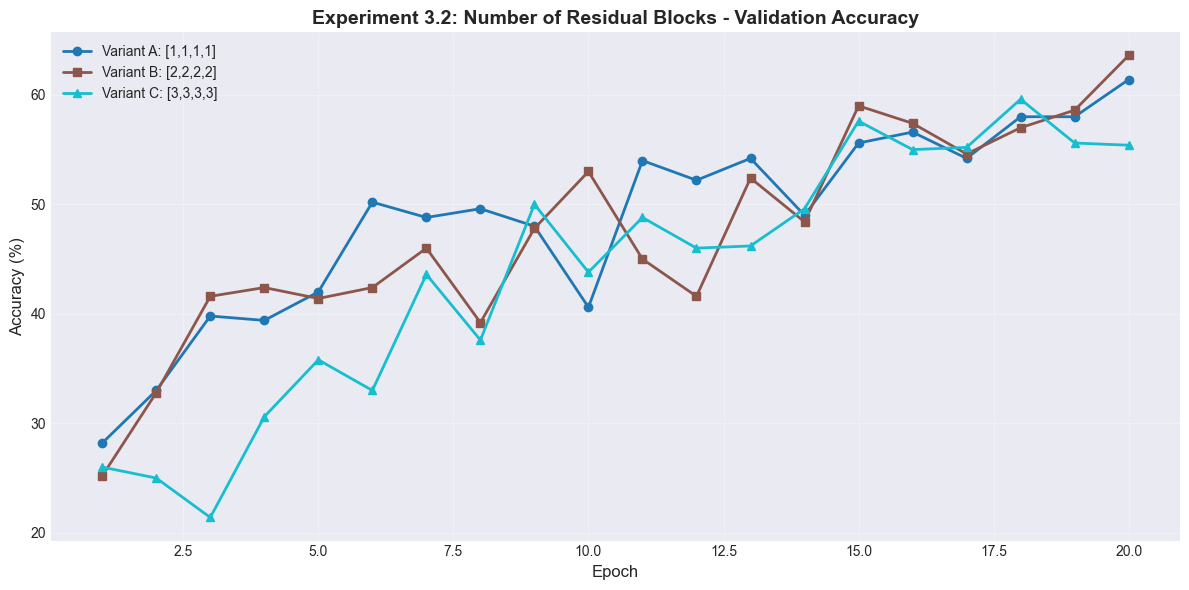


Лучшая конфигурация: вариант B: [2,2,2,2]
Лучшая Val Accuracy: 63.60%
Скорость сходимости:
- Вариант A достигла 40.60% на эпохе 10
- Вариант B достигла 53.00% на эпохе 10
- Вариант C достигла 43.80% на эпохе 10
Признаки переобучения (Train-Val gap):
- A: [1,1,1,1]: 4.40% (Слабое)
- B: [2,2,2,2]: 4.62% (Слабое)
- C: [3,3,3,3]: 6.94% (Умеренное)
Выводы:
- Более глубокие модели имеют больше параметров
- Оптимальная глубина: [2, 2, 2, 2]
- Глубокие модели могут переобучаться на малых датасетах


In [ ]:
print('Вариант A: [1, 1, 1, 1] - по 1 блоку в каждом слое (мелкая сеть)')

model_3_2_a = ResNet18(
    num_classes=NUM_CLASSES,
    channels=best_channels_3_1,
    num_blocks=[1] * len(best_channels_3_1),
    activation=nn.ReLU
)

print(f'Parameters: {count_parameters(model_3_2_a)}')

model_3_2_a, history_3_2_a, best_acc_3_2_a = train_model(
    model_3_2_a, train_loader, val_loader, num_epochs=20, lr=0.001, device=device
)

print('Вариант B: [2, 2, 2, 2] - по 2 блока в каждом слое (стандартная ResNet18)')

model_3_2_b = ResNet18(
    num_classes=NUM_CLASSES,
    channels=best_channels_3_1,
    num_blocks=[2] * len(best_channels_3_1),
    activation=nn.ReLU
)

print(f'Parameters: {count_parameters(model_3_2_b)}')

model_3_2_b, history_3_2_b, best_acc_3_2_b = train_model(
    model_3_2_b, train_loader, val_loader, num_epochs=20, lr=0.001, device=device
)

print('Вариант C: [3, 3, 3, 3] - по 3 блока в каждом слое (глубокая сеть)')

model_3_2_c = ResNet18(
    num_classes=NUM_CLASSES,
    channels=best_channels_3_1,
    num_blocks=[3] * len(best_channels_3_1),
    activation=nn.ReLU
)

print(f'Parameters: {count_parameters(model_3_2_c)}')

model_3_2_c, history_3_2_c, best_acc_3_2_c = train_model(
    model_3_2_c, train_loader, val_loader, num_epochs=20, lr=0.001, device=device
)

results_3_2 = pd.DataFrame({
    'Variant': ['A: [1,1,1,1]', 'B: [2,2,2,2]', 'C: [3,3,3,3]'],
    'Total Blocks': [len(best_channels_3_1), len(best_channels_3_1)*2, len(best_channels_3_1)*3],
    'Parameters': [
        f'{count_parameters(model_3_2_a)}',
        f'{count_parameters(model_3_2_b)}',
        f'{count_parameters(model_3_2_c)}'
    ],
    'Best Val Acc (%)': [
        f'{best_acc_3_2_a:.2f}',
        f'{best_acc_3_2_b:.2f}',
        f'{best_acc_3_2_c:.2f}'
    ],
    'Final Train Acc (%)': [
        f'{history_3_2_a["train_acc"][-1]:.2f}',
        f'{history_3_2_b["train_acc"][-1]:.2f}',
        f'{history_3_2_c["train_acc"][-1]:.2f}'
    ]
})

print('\n', results_3_2.to_string(index=False))

plot_multiple_histories(
    [history_3_2_a, history_3_2_b, history_3_2_c],
    ['Variant A: [1,1,1,1]', 'Variant B: [2,2,2,2]', 'Variant C: [3,3,3,3]'],
    metric='val_acc',
    title='Experiment 3.2: Number of Residual Blocks'
)

best_acc_list = [best_acc_3_2_a, best_acc_3_2_b, best_acc_3_2_c]
best_idx = best_acc_list.index(max(best_acc_list))
variants = ['A: [1,1,1,1]', 'B: [2,2,2,2]', 'C: [3,3,3,3]']
num_blocks_list = [[1]*len(best_channels_3_1), [2]*len(best_channels_3_1), [3]*len(best_channels_3_1)]

best_num_blocks = num_blocks_list[best_idx]

print(f'\nЛучшая конфигурация: вариант {variants[best_idx]}')
print(f'Лучшая Val Accuracy: {max(best_acc_list):.2f}%')
print(f'Скорость сходимости:')
print(f'- Вариант A достигла {history_3_2_a["val_acc"][9]:.2f}% на эпохе 10')
print(f'- Вариант B достигла {history_3_2_b["val_acc"][9]:.2f}% на эпохе 10')
print(f'- Вариант C достигла {history_3_2_c["val_acc"][9]:.2f}% на эпохе 10')

overfitting_gaps = [
    history_3_2_a['train_acc'][-1] - history_3_2_a['val_acc'][-1],
    history_3_2_b['train_acc'][-1] - history_3_2_b['val_acc'][-1],
    history_3_2_c['train_acc'][-1] - history_3_2_c['val_acc'][-1]
]

print(f'Признаки переобучения (Train-Val gap):')
for i, (var, gap) in enumerate(zip(variants, overfitting_gaps)):
    status = 'Сильное' if gap > 10 else 'Умеренное' if gap > 5 else 'Слабое'
    print(f'- {var}: {gap:.2f}% ({status})')

print(f'Выводы:')
print(f'- Более глубокие модели имеют больше параметров')
print(f'- Оптимальная глубина: {best_num_blocks}')
print(f'- Глубокие модели могут переобучаться на малых датасетах')

best_num_blocks_3_2 = best_num_blocks

### 3.3 Эксперименты с функциями активации

**Цель:** Исследование влияния различных активаций на обучение.

**Модификация модели:** Замените ReLU на другие функции активации:

**Эксперимент:**

- Используйте лучшую конфигурацию из Этапа 3.2 (каналы + количество блоков)
- Обучите модели с разными активациями:
    - Вариант A: ReLU (baseline)
    - Вариант B: LeakyReLU
    - Вариант C: ELU
    - Вариант D: GELU
**Важно:** Используйте `inplace=True` где возможно для экономии памяти

**Результат:**

- Сравнение скорости сходимости (accuracy на каждой эпохе)
- Финальная validation accuracy
- Вывод: какая активация работает лучше?

Вариант A: ReLU (baseline)
Parameters: 2797610
Starting training for 20 epochs...


Epoch 1/20 | Train Loss: 2.0628 | Train Acc: 25.34% | Val Loss: 2.0258 | Val Acc: 30.20% | Best Val Acc: 30.20%


Epoch 2/20 | Train Loss: 1.8741 | Train Acc: 32.20% | Val Loss: 1.8559 | Val Acc: 30.80% | Best Val Acc: 30.80%


Epoch 3/20 | Train Loss: 1.7395 | Train Acc: 38.74% | Val Loss: 1.6793 | Val Acc: 39.80% | Best Val Acc: 39.80%


Epoch 4/20 | Train Loss: 1.6292 | Train Acc: 42.30% | Val Loss: 2.1440 | Val Acc: 35.40% | Best Val Acc: 39.80%


Epoch 5/20 | Train Loss: 1.5523 | Train Acc: 45.58% | Val Loss: 1.5572 | Val Acc: 46.20% | Best Val Acc: 46.20%


Epoch 6/20 | Train Loss: 1.4951 | Train Acc: 47.72% | Val Loss: 1.5142 | Val Acc: 45.20% | Best Val Acc: 46.20%


Epoch 7/20 | Train Loss: 1.4138 | Train Acc: 50.62% | Val Loss: 1.5229 | Val Acc: 44.20% | Best Val Acc: 46.20%


Epoch 8/20 | Train Loss: 1.3569 | Train Acc: 52.30% | Val Loss: 1.4918 | Val Acc: 48.40% | Best Val Acc: 48.40%


Epoch 9/20 | Train Loss: 1.3371 | Train Acc: 53.68% | Val Loss: 1.5362 | Val Acc: 48.80% | Best Val Acc: 48.80%


Epoch 10/20 | Train Loss: 1.2773 | Train Acc: 55.64% | Val Loss: 1.4537 | Val Acc: 49.40% | Best Val Acc: 49.40%


Epoch 11/20 | Train Loss: 1.2734 | Train Acc: 55.78% | Val Loss: 2.2273 | Val Acc: 38.20% | Best Val Acc: 49.40%


Epoch 12/20 | Train Loss: 1.1967 | Train Acc: 58.76% | Val Loss: 1.5190 | Val Acc: 49.40% | Best Val Acc: 49.40%


Epoch 13/20 | Train Loss: 1.1964 | Train Acc: 59.22% | Val Loss: 1.3310 | Val Acc: 54.40% | Best Val Acc: 54.40%


Epoch 14/20 | Train Loss: 1.1499 | Train Acc: 60.56% | Val Loss: 1.3408 | Val Acc: 52.40% | Best Val Acc: 54.40%


Epoch 15/20 | Train Loss: 1.1253 | Train Acc: 61.42% | Val Loss: 1.2589 | Val Acc: 56.20% | Best Val Acc: 56.20%


Epoch 16/20 | Train Loss: 1.0837 | Train Acc: 63.24% | Val Loss: 1.3584 | Val Acc: 56.00% | Best Val Acc: 56.20%


Epoch 17/20 | Train Loss: 1.0665 | Train Acc: 63.50% | Val Loss: 1.3886 | Val Acc: 54.80% | Best Val Acc: 56.20%


Epoch 18/20 | Train Loss: 1.0378 | Train Acc: 64.70% | Val Loss: 1.2545 | Val Acc: 58.60% | Best Val Acc: 58.60%


Epoch 19/20 | Train Loss: 1.0216 | Train Acc: 64.02% | Val Loss: 1.2866 | Val Acc: 59.80% | Best Val Acc: 59.80%


Epoch 20/20 | Train Loss: 1.0203 | Train Acc: 64.70% | Val Loss: 1.1935 | Val Acc: 60.60% | Best Val Acc: 60.60%
Training completed! Best Val Acc: 60.60%
Вариант B: LeakyReLU
Parameters: 2797610
Starting training for 20 epochs...


Epoch 1/20 | Train Loss: 2.0776 | Train Acc: 24.08% | Val Loss: 1.9863 | Val Acc: 25.60% | Best Val Acc: 25.60%


Epoch 2/20 | Train Loss: 1.9266 | Train Acc: 30.80% | Val Loss: 1.9627 | Val Acc: 31.40% | Best Val Acc: 31.40%


Epoch 3/20 | Train Loss: 1.8164 | Train Acc: 34.20% | Val Loss: 1.7722 | Val Acc: 34.40% | Best Val Acc: 34.40%


Epoch 4/20 | Train Loss: 1.7119 | Train Acc: 38.48% | Val Loss: 1.8698 | Val Acc: 35.80% | Best Val Acc: 35.80%


Epoch 5/20 | Train Loss: 1.6244 | Train Acc: 41.82% | Val Loss: 1.9264 | Val Acc: 37.00% | Best Val Acc: 37.00%


Epoch 6/20 | Train Loss: 1.5882 | Train Acc: 44.18% | Val Loss: 1.6925 | Val Acc: 40.40% | Best Val Acc: 40.40%


Epoch 7/20 | Train Loss: 1.5062 | Train Acc: 47.48% | Val Loss: 1.8853 | Val Acc: 40.20% | Best Val Acc: 40.40%


Epoch 8/20 | Train Loss: 1.4733 | Train Acc: 47.98% | Val Loss: 1.5450 | Val Acc: 46.20% | Best Val Acc: 46.20%


Epoch 9/20 | Train Loss: 1.3884 | Train Acc: 51.46% | Val Loss: 1.4089 | Val Acc: 51.20% | Best Val Acc: 51.20%


Epoch 10/20 | Train Loss: 1.3666 | Train Acc: 52.68% | Val Loss: 1.4371 | Val Acc: 50.80% | Best Val Acc: 51.20%


Epoch 11/20 | Train Loss: 1.2830 | Train Acc: 55.20% | Val Loss: 1.4359 | Val Acc: 50.60% | Best Val Acc: 51.20%


Epoch 12/20 | Train Loss: 1.2557 | Train Acc: 56.36% | Val Loss: 1.9106 | Val Acc: 39.60% | Best Val Acc: 51.20%


Epoch 13/20 | Train Loss: 1.2233 | Train Acc: 57.52% | Val Loss: 1.3500 | Val Acc: 54.20% | Best Val Acc: 54.20%


Epoch 14/20 | Train Loss: 1.2287 | Train Acc: 57.66% | Val Loss: 1.4453 | Val Acc: 52.80% | Best Val Acc: 54.20%


Epoch 15/20 | Train Loss: 1.1810 | Train Acc: 59.26% | Val Loss: 1.3579 | Val Acc: 54.80% | Best Val Acc: 54.80%


Epoch 16/20 | Train Loss: 1.1477 | Train Acc: 60.24% | Val Loss: 1.4626 | Val Acc: 52.60% | Best Val Acc: 54.80%


Epoch 17/20 | Train Loss: 1.1485 | Train Acc: 60.62% | Val Loss: 1.3195 | Val Acc: 55.80% | Best Val Acc: 55.80%


Epoch 18/20 | Train Loss: 1.1102 | Train Acc: 62.56% | Val Loss: 1.6026 | Val Acc: 49.60% | Best Val Acc: 55.80%


Epoch 19/20 | Train Loss: 1.0658 | Train Acc: 63.26% | Val Loss: 1.3450 | Val Acc: 56.00% | Best Val Acc: 56.00%


Epoch 20/20 | Train Loss: 1.0455 | Train Acc: 63.92% | Val Loss: 1.2212 | Val Acc: 56.40% | Best Val Acc: 56.40%
Training completed! Best Val Acc: 56.40%
Вариант C: ELU
Parameters: 2797610
Starting training for 20 epochs...


Epoch 1/20 | Train Loss: 2.0956 | Train Acc: 23.76% | Val Loss: 2.1166 | Val Acc: 25.60% | Best Val Acc: 25.60%


Epoch 2/20 | Train Loss: 2.0140 | Train Acc: 27.82% | Val Loss: 2.0211 | Val Acc: 27.00% | Best Val Acc: 27.00%


Epoch 3/20 | Train Loss: 1.9061 | Train Acc: 32.18% | Val Loss: 2.1538 | Val Acc: 27.80% | Best Val Acc: 27.80%


Epoch 4/20 | Train Loss: 1.8391 | Train Acc: 34.10% | Val Loss: 2.1577 | Val Acc: 28.60% | Best Val Acc: 28.60%


Epoch 5/20 | Train Loss: 1.7688 | Train Acc: 37.42% | Val Loss: 1.7978 | Val Acc: 35.40% | Best Val Acc: 35.40%


Epoch 6/20 | Train Loss: 1.6719 | Train Acc: 41.80% | Val Loss: 1.6679 | Val Acc: 40.80% | Best Val Acc: 40.80%


Epoch 7/20 | Train Loss: 1.6292 | Train Acc: 43.00% | Val Loss: 1.5753 | Val Acc: 44.60% | Best Val Acc: 44.60%


Epoch 8/20 | Train Loss: 1.5417 | Train Acc: 46.46% | Val Loss: 1.5602 | Val Acc: 47.80% | Best Val Acc: 47.80%


Epoch 9/20 | Train Loss: 1.5152 | Train Acc: 47.40% | Val Loss: 1.6929 | Val Acc: 41.20% | Best Val Acc: 47.80%


Epoch 10/20 | Train Loss: 1.4722 | Train Acc: 48.38% | Val Loss: 1.6900 | Val Acc: 45.00% | Best Val Acc: 47.80%


Epoch 11/20 | Train Loss: 1.4527 | Train Acc: 49.44% | Val Loss: 1.5379 | Val Acc: 49.60% | Best Val Acc: 49.60%


Epoch 12/20 | Train Loss: 1.4140 | Train Acc: 50.74% | Val Loss: 1.4903 | Val Acc: 48.40% | Best Val Acc: 49.60%


Epoch 13/20 | Train Loss: 1.3958 | Train Acc: 51.92% | Val Loss: 1.5368 | Val Acc: 46.40% | Best Val Acc: 49.60%


Epoch 14/20 | Train Loss: 1.3804 | Train Acc: 52.44% | Val Loss: 1.4724 | Val Acc: 46.20% | Best Val Acc: 49.60%


Epoch 15/20 | Train Loss: 1.3777 | Train Acc: 52.84% | Val Loss: 1.4495 | Val Acc: 50.20% | Best Val Acc: 50.20%


Epoch 16/20 | Train Loss: 1.3307 | Train Acc: 54.10% | Val Loss: 1.4451 | Val Acc: 49.80% | Best Val Acc: 50.20%


Epoch 17/20 | Train Loss: 1.3106 | Train Acc: 55.16% | Val Loss: 1.4107 | Val Acc: 51.00% | Best Val Acc: 51.00%


Epoch 18/20 | Train Loss: 1.2946 | Train Acc: 55.38% | Val Loss: 1.5224 | Val Acc: 48.00% | Best Val Acc: 51.00%


Epoch 19/20 | Train Loss: 1.2737 | Train Acc: 56.86% | Val Loss: 1.3027 | Val Acc: 55.00% | Best Val Acc: 55.00%


Epoch 20/20 | Train Loss: 1.2458 | Train Acc: 57.20% | Val Loss: 1.2730 | Val Acc: 55.80% | Best Val Acc: 55.80%
Training completed! Best Val Acc: 55.80%

      Variant Best Val Acc (%) Final Train Acc (%) Epoch 10 Val Acc (%) Convergence Speed
     A: ReLU            60.60               64.70                49.40          Baseline
B: LeakyReLU            56.40               63.92                50.80              Slow
      C: ELU            55.80               57.20                45.00              Slow


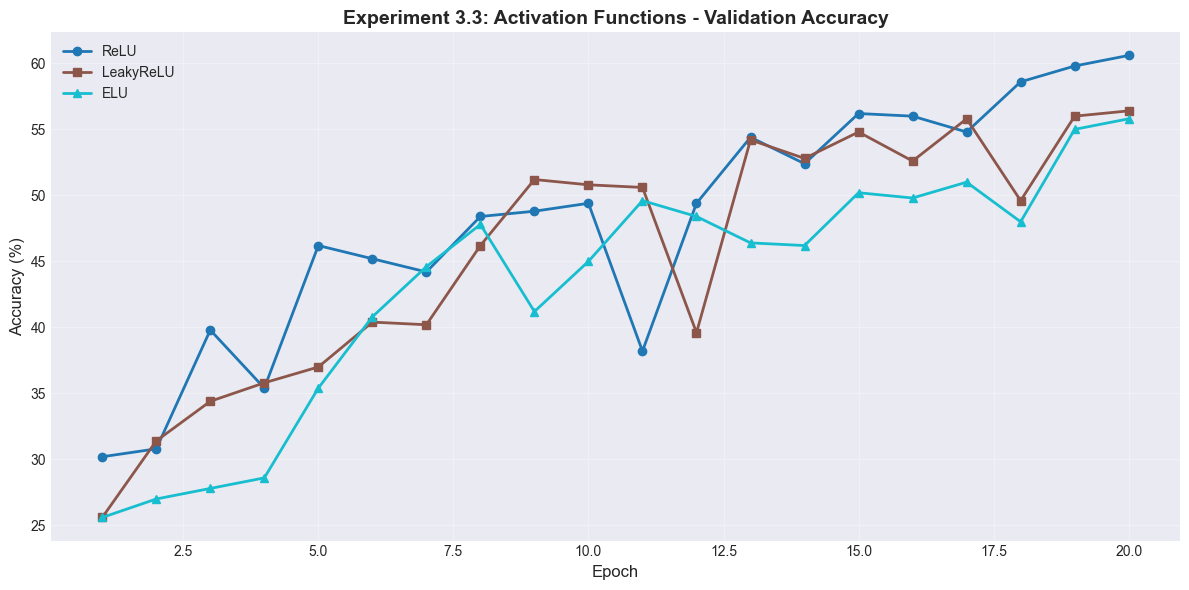

Лучшая функция активации: ReLU
Лучшая Val Accuracy: 60.60%
Скорость сходимости (Val Acc на эпохе 10):
- ReLU: 49.40%
- LeakyReLU: 50.80%
- ELU: 45.00%
Финальная производительность:
- ReLU: 60.60% (0.00% vs ReLU)
- LeakyReLU: 56.40% (-4.20% vs ReLU)
- ELU: 55.80% (-4.80% vs ReLU)
Выводы:
- ReLU показала лучшие результаты
- Разница между лучшей и худшей: 4.80%
- Все активации сходятся, но с разной скоростью


In [21]:
print('Вариант A: ReLU (baseline)')

model_3_3_a = ResNet18(
    num_classes=NUM_CLASSES,
    channels=best_channels_3_1,
    num_blocks=best_num_blocks_3_2,
    activation=nn.ReLU
)

print(f'Parameters: {count_parameters(model_3_3_a)}')

model_3_3_a, history_3_3_a, best_acc_3_3_a = train_model(
    model_3_3_a, train_loader, val_loader, num_epochs=20, lr=0.001, device=device
)

print('Вариант B: LeakyReLU')

model_3_3_b = ResNet18(
    num_classes=NUM_CLASSES,
    channels=best_channels_3_1,
    num_blocks=best_num_blocks_3_2,
    activation=nn.LeakyReLU
)

print(f'Parameters: {count_parameters(model_3_3_b)}')

model_3_3_b, history_3_3_b, best_acc_3_3_b = train_model(
    model_3_3_b, train_loader, val_loader, num_epochs=20, lr=0.001, device=device
)

print('Вариант C: ELU')

model_3_3_c = ResNet18(
    num_classes=NUM_CLASSES,
    channels=best_channels_3_1,
    num_blocks=best_num_blocks_3_2,
    activation=nn.ELU
)

print(f'Parameters: {count_parameters(model_3_3_c)}')

model_3_3_c, history_3_3_c, best_acc_3_3_c = train_model(
    model_3_3_c, train_loader, val_loader, num_epochs=20, lr=0.001, device=device
)

results_3_3 = pd.DataFrame({
    'Variant': ['A: ReLU', 'B: LeakyReLU', 'C: ELU'],
    'Best Val Acc (%)': [
        f'{best_acc_3_3_a:.2f}',
        f'{best_acc_3_3_b:.2f}',
        f'{best_acc_3_3_c:.2f}',
    ],
    'Final Train Acc (%)': [
        f'{history_3_3_a["train_acc"][-1]:.2f}',
        f'{history_3_3_b["train_acc"][-1]:.2f}',
        f'{history_3_3_c["train_acc"][-1]:.2f}',
    ],
    'Epoch 10 Val Acc (%)': [
        f'{history_3_3_a["val_acc"][9]:.2f}',
        f'{history_3_3_b["val_acc"][9]:.2f}',
        f'{history_3_3_c["val_acc"][9]:.2f}',
    ],
    'Convergence Speed': [
        'Baseline',
        'Fast' if best_acc_3_3_b > best_acc_3_3_a else 'Slow',
        'Fast' if best_acc_3_3_c > best_acc_3_3_a else 'Slow',
    ]
})

print('\n', results_3_3.to_string(index=False))

plot_multiple_histories(
    [history_3_3_a, history_3_3_b, history_3_3_c],
    ['ReLU', 'LeakyReLU', 'ELU'],
    metric='val_acc',
    title='Experiment 3.3: Activation Functions'
)

best_acc_list = [best_acc_3_3_a, best_acc_3_3_b, best_acc_3_3_c]
activations = ['ReLU', 'LeakyReLU', 'ELU']
activation_classes = [nn.ReLU, nn.LeakyReLU, nn.ELU]
best_idx = best_acc_list.index(max(best_acc_list))

best_activation = activations[best_idx]
best_activation_class = activation_classes[best_idx]

print(f'Лучшая функция активации: {best_activation}')
print(f'Лучшая Val Accuracy: {max(best_acc_list):.2f}%')

print(f'Скорость сходимости (Val Acc на эпохе 10):')
for act, hist in zip(activations, [history_3_3_a, history_3_3_b, history_3_3_c]):
    print(f'- {act}: {hist["val_acc"][9]:.2f}%')

print(f'Финальная производительность:')
for act, acc in zip(activations, best_acc_list):
    diff = acc - best_acc_3_3_a
    sign = '+' if diff > 0 else ''
    print(f'- {act}: {acc:.2f}% ({sign}{diff:.2f}% vs ReLU)')

print(f'Выводы:')
print(f'- {best_activation} показала лучшие результаты')
print(f'- Разница между лучшей и худшей: {max(best_acc_list) - min(best_acc_list):.2f}%')
print(f'- Все активации сходятся, но с разной скоростью')

best_activation_3_3 = best_activation_class

## Часть 4: Финальная модель и тестирование

### 4.1 Создание финальной модели
На основе всех экспериментов:

- Выберите лучшую конфигурацию каналов (из Этапа 3.1)
- Выберите оптимальное количество residual блоков (из Этапа 3.2) - объясните, почему выбрали именно это количество
- Выберите лучшую функцию активации (из Этапа 3.3)
- Обучите финальную модель на 30-40 эпох с выбранными параметрами

**Дополнительно (опционально):**

- Добавьте data augmentation
- Попробуйте другие оптимизаторы (AdamW как вариант)

- Channels: [32, 64, 128, 256] (из эксперимента 3.1)
- Blocks: [2, 2, 2, 2] (из эксперимента 3.2)
- Activation: ReLU (из эксперимента 3.3)
Parameters: 2797610

Epoch 1/30


✓ New best model! Val Acc: 28.60%
Train Loss: 2.0693 | Train Acc: 24.36%
Val Loss: 1.9754 | Val Acc: 28.60%
Best Val Acc: 28.60%
LR: 0.000997

Epoch 2/30


✓ New best model! Val Acc: 30.20%
Train Loss: 1.8691 | Train Acc: 32.32%
Val Loss: 1.9693 | Val Acc: 30.20%
Best Val Acc: 30.20%
LR: 0.000989

Epoch 3/30


✓ New best model! Val Acc: 35.20%
Train Loss: 1.7452 | Train Acc: 37.90%
Val Loss: 1.8979 | Val Acc: 35.20%
Best Val Acc: 35.20%
LR: 0.000976

Epoch 4/30


✓ New best model! Val Acc: 37.60%
Train Loss: 1.6598 | Train Acc: 41.34%
Val Loss: 1.7033 | Val Acc: 37.60%
Best Val Acc: 37.60%
LR: 0.000957

Epoch 5/30


Train Loss: 1.5595 | Train Acc: 45.50%
Val Loss: 2.1334 | Val Acc: 32.00%
Best Val Acc: 37.60%
LR: 0.000933

Epoch 6/30


✓ New best model! Val Acc: 45.60%
Train Loss: 1.4834 | Train Acc: 48.08%
Val Loss: 1.6386 | Val Acc: 45.60%
Best Val Acc: 45.60%
LR: 0.000905

Epoch 7/30


✓ New best model! Val Acc: 46.60%
Train Loss: 1.4299 | Train Acc: 49.74%
Val Loss: 1.7100 | Val Acc: 46.60%
Best Val Acc: 46.60%
LR: 0.000872

Epoch 8/30


Train Loss: 1.3296 | Train Acc: 53.34%
Val Loss: 1.7159 | Val Acc: 42.20%
Best Val Acc: 46.60%
LR: 0.000835

Epoch 9/30


✓ New best model! Val Acc: 50.60%
Train Loss: 1.2980 | Train Acc: 55.64%
Val Loss: 1.5197 | Val Acc: 50.60%
Best Val Acc: 50.60%
LR: 0.000794

Epoch 10/30


✓ New best model! Val Acc: 56.80%
Train Loss: 1.2423 | Train Acc: 57.56%
Val Loss: 1.2973 | Val Acc: 56.80%
Best Val Acc: 56.80%
LR: 0.000750

Epoch 11/30


Train Loss: 1.1900 | Train Acc: 59.32%
Val Loss: 1.2738 | Val Acc: 55.40%
Best Val Acc: 56.80%
LR: 0.000704

Epoch 12/30


✓ New best model! Val Acc: 59.20%
Train Loss: 1.1282 | Train Acc: 61.10%
Val Loss: 1.2023 | Val Acc: 59.20%
Best Val Acc: 59.20%
LR: 0.000655

Epoch 13/30


Train Loss: 1.1246 | Train Acc: 61.42%
Val Loss: 1.3757 | Val Acc: 54.60%
Best Val Acc: 59.20%
LR: 0.000604

Epoch 14/30


Train Loss: 1.0864 | Train Acc: 62.82%
Val Loss: 1.4215 | Val Acc: 52.80%
Best Val Acc: 59.20%
LR: 0.000553

Epoch 15/30


Train Loss: 1.0415 | Train Acc: 64.48%
Val Loss: 1.2191 | Val Acc: 58.60%
Best Val Acc: 59.20%
LR: 0.000501

Epoch 16/30


Train Loss: 0.9978 | Train Acc: 65.74%
Val Loss: 1.2714 | Val Acc: 58.60%
Best Val Acc: 59.20%
LR: 0.000448

Epoch 17/30


✓ New best model! Val Acc: 62.60%
Train Loss: 0.9752 | Train Acc: 66.78%
Val Loss: 1.1716 | Val Acc: 62.60%
Best Val Acc: 62.60%
LR: 0.000397

Epoch 18/30


Train Loss: 0.9249 | Train Acc: 68.58%
Val Loss: 1.1706 | Val Acc: 59.80%
Best Val Acc: 62.60%
LR: 0.000346

Epoch 19/30


✓ New best model! Val Acc: 64.40%
Train Loss: 0.8892 | Train Acc: 69.06%
Val Loss: 1.0411 | Val Acc: 64.40%
Best Val Acc: 64.40%
LR: 0.000297

Epoch 20/30


Train Loss: 0.8714 | Train Acc: 70.16%
Val Loss: 1.0679 | Val Acc: 63.60%
Best Val Acc: 64.40%
LR: 0.000251

Epoch 21/30


✓ New best model! Val Acc: 64.60%
Train Loss: 0.8300 | Train Acc: 71.72%
Val Loss: 1.0341 | Val Acc: 64.60%
Best Val Acc: 64.60%
LR: 0.000207

Epoch 22/30


Train Loss: 0.8135 | Train Acc: 72.08%
Val Loss: 1.0608 | Val Acc: 63.20%
Best Val Acc: 64.60%
LR: 0.000166

Epoch 23/30


Train Loss: 0.7794 | Train Acc: 73.14%
Val Loss: 1.0806 | Val Acc: 62.60%
Best Val Acc: 64.60%
LR: 0.000129

Epoch 24/30


Train Loss: 0.7551 | Train Acc: 74.04%
Val Loss: 1.0299 | Val Acc: 64.20%
Best Val Acc: 64.60%
LR: 0.000096

Epoch 25/30


✓ New best model! Val Acc: 64.80%
Train Loss: 0.7307 | Train Acc: 74.86%
Val Loss: 1.0480 | Val Acc: 64.80%
Best Val Acc: 64.80%
LR: 0.000068

Epoch 26/30


✓ New best model! Val Acc: 65.20%
Train Loss: 0.7076 | Train Acc: 75.56%
Val Loss: 1.0439 | Val Acc: 65.20%
Best Val Acc: 65.20%
LR: 0.000044

Epoch 27/30


✓ New best model! Val Acc: 66.80%
Train Loss: 0.6999 | Train Acc: 75.88%
Val Loss: 1.0177 | Val Acc: 66.80%
Best Val Acc: 66.80%
LR: 0.000025

Epoch 28/30


Train Loss: 0.6927 | Train Acc: 76.24%
Val Loss: 1.0313 | Val Acc: 66.40%
Best Val Acc: 66.80%
LR: 0.000012

Epoch 29/30


Train Loss: 0.6737 | Train Acc: 77.00%
Val Loss: 1.0196 | Val Acc: 66.40%
Best Val Acc: 66.80%
LR: 0.000004

Epoch 30/30


Train Loss: 0.6761 | Train Acc: 76.82%
Val Loss: 1.0106 | Val Acc: 65.80%
Best Val Acc: 66.80%
LR: 0.000001
Best Validation Accuracy: 66.80%
Final Train Accuracy: 76.82%
Model saved to: best_resnet18_model.pth


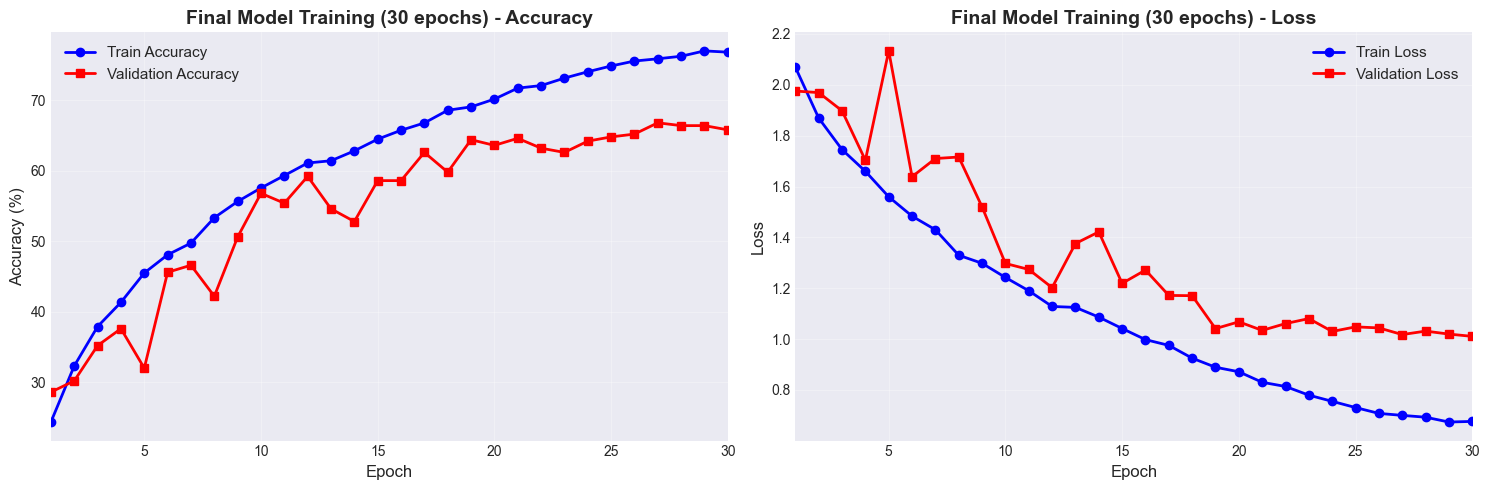

In [22]:
print(f'- Channels: {best_channels_3_1} (из эксперимента 3.1)')
print(f'- Blocks: {best_num_blocks_3_2} (из эксперимента 3.2)')
print(f'- Activation: {best_activation} (из эксперимента 3.3)')

final_model = ResNet18(
    num_classes=NUM_CLASSES,
    channels=best_channels_3_1,
    num_blocks=best_num_blocks_3_2,
    activation=best_activation_3_3
)

print(f'Parameters: {count_parameters(final_model)}')

final_model = final_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(final_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

final_history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_final_acc = 0.0
best_final_state = None

for epoch in range(30):
    print(f'\nEpoch {epoch+1}/30')
    
    train_loss, train_acc = train_epoch(final_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(final_model, val_loader, criterion, device)
    
    final_history['train_loss'].append(train_loss)
    final_history['train_acc'].append(train_acc)
    final_history['val_loss'].append(val_loss)
    final_history['val_acc'].append(val_acc)
    
    scheduler.step()
    
    if val_acc > best_final_acc:
        best_final_acc = val_acc
        best_final_state = final_model.state_dict().copy()
        print(f'✓ New best model! Val Acc: {val_acc:.2f}%')
    
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print(f'Best Val Acc: {best_final_acc:.2f}%')
    print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

final_model.load_state_dict(best_final_state)

torch.save({
    'model_state_dict': best_final_state,
    'channels': best_channels_3_1,
    'num_blocks': best_num_blocks_3_2,
    'activation': best_activation,
    'best_val_acc': best_final_acc,
    'history': final_history
}, 'best_resnet18_model.pth')

print(f'Best Validation Accuracy: {best_final_acc:.2f}%')
print(f'Final Train Accuracy: {final_history["train_acc"][-1]:.2f}%')
print(f'Model saved to: best_resnet18_model.pth')

plot_training_history(final_history, 'Final Model Training (30 epochs)')

### 4.2 Тестирование на test set

Computing metrics: 100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

Test Accuracy: 65.80%


   Class  Precision  Recall  F1-Score  Support
Class 0   0.901961    0.92  0.910891       50
Class 1   0.814815    0.88  0.846154       50
Class 2   0.519231    0.54  0.529412       50
Class 3   0.454545    0.50  0.476190       50
Class 4   0.615385    0.64  0.627451       50
Class 5   0.531250    0.34  0.414634       50
Class 6   0.812500    0.78  0.795918       50
Class 7   0.457627    0.54  0.495413       50
Class 8   0.847826    0.78  0.812500       50
Class 9   0.647059    0.66  0.653465       50
Macro Average:
  Precision: 0.6602
  Recall: 0.6580
  F1-Score: 0.6562

Weighted Average:
  Precision: 0.6602
  Recall: 0.6580
  F1-Score: 0.6562


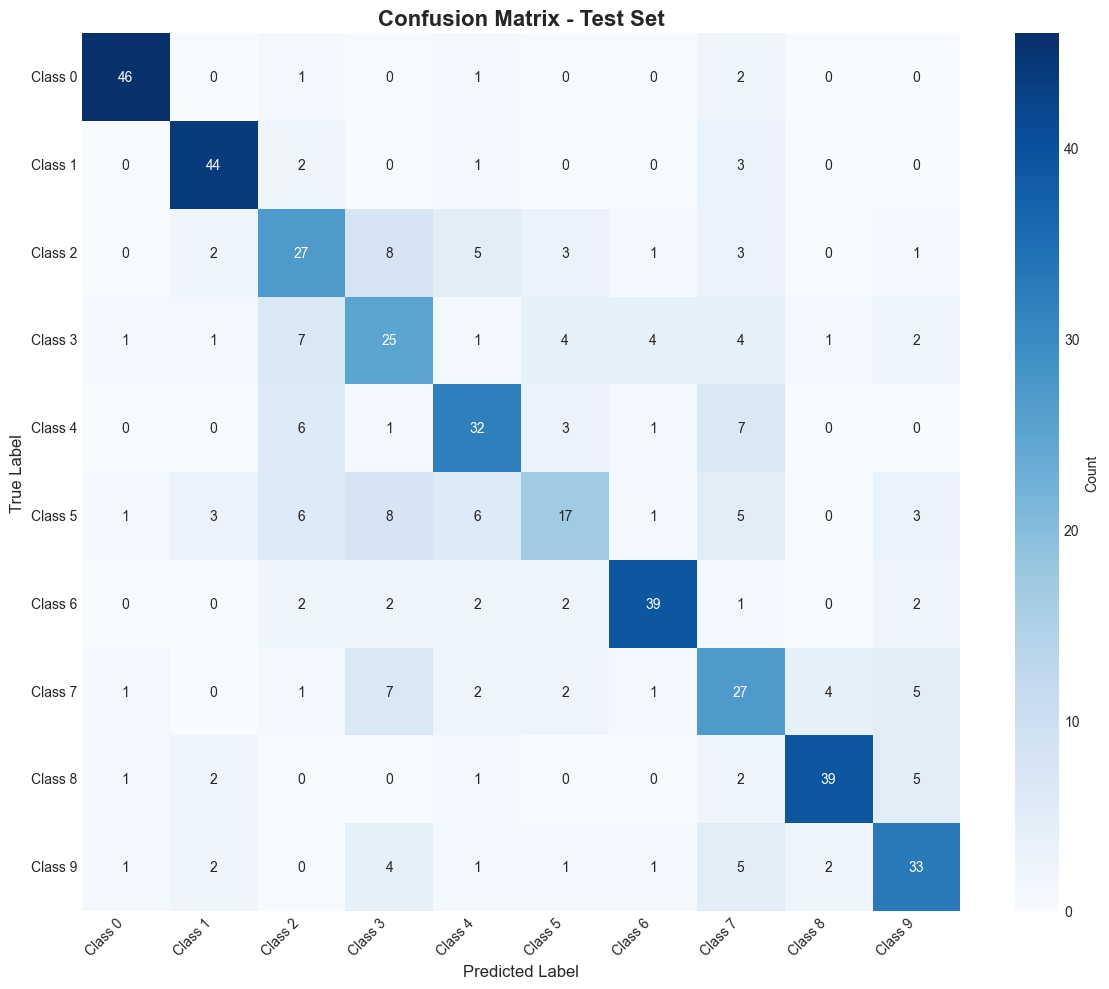

In [23]:
def compute_detailed_metrics(model, data_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc='Computing metrics'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = 100. * (all_preds == all_labels).sum() / len(all_labels)
    
    class_report = classification_report(
        all_labels, all_preds,
        target_names=class_names,
        output_dict=True
    )
    
    return accuracy, all_preds, all_labels, class_report

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

checkpoint = torch.load('best_resnet18_model.pth')
final_model.load_state_dict(checkpoint['model_state_dict'])

test_loader = val_loader

class_names = [f'Class {i}' for i in range(NUM_CLASSES)]
test_acc, test_preds, test_labels, class_report = compute_detailed_metrics(
    final_model, test_loader, device, class_names
)

print(f'Test Accuracy: {test_acc:.2f}%\n')

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': [class_report[cls]['precision'] for cls in class_names],
    'Recall': [class_report[cls]['recall'] for cls in class_names],
    'F1-Score': [class_report[cls]['f1-score'] for cls in class_names],
    'Support': [int(class_report[cls]['support']) for cls in class_names]
})

print('\n', metrics_df.to_string(index=False))

print(f'Macro Average:')
print(f"  Precision: {class_report['macro avg']['precision']:.4f}")
print(f"  Recall: {class_report['macro avg']['recall']:.4f}")
print(f"  F1-Score: {class_report['macro avg']['f1-score']:.4f}")

print(f'\nWeighted Average:')
print(f"  Precision: {class_report['weighted avg']['precision']:.4f}")
print(f"  Recall: {class_report['weighted avg']['recall']:.4f}")
print(f"  F1-Score: {class_report['weighted avg']['f1-score']:.4f}")

plot_confusion_matrix(test_labels, test_preds, class_names, 'Confusion Matrix - Test Set')

### 4.3 Визуальный анализ

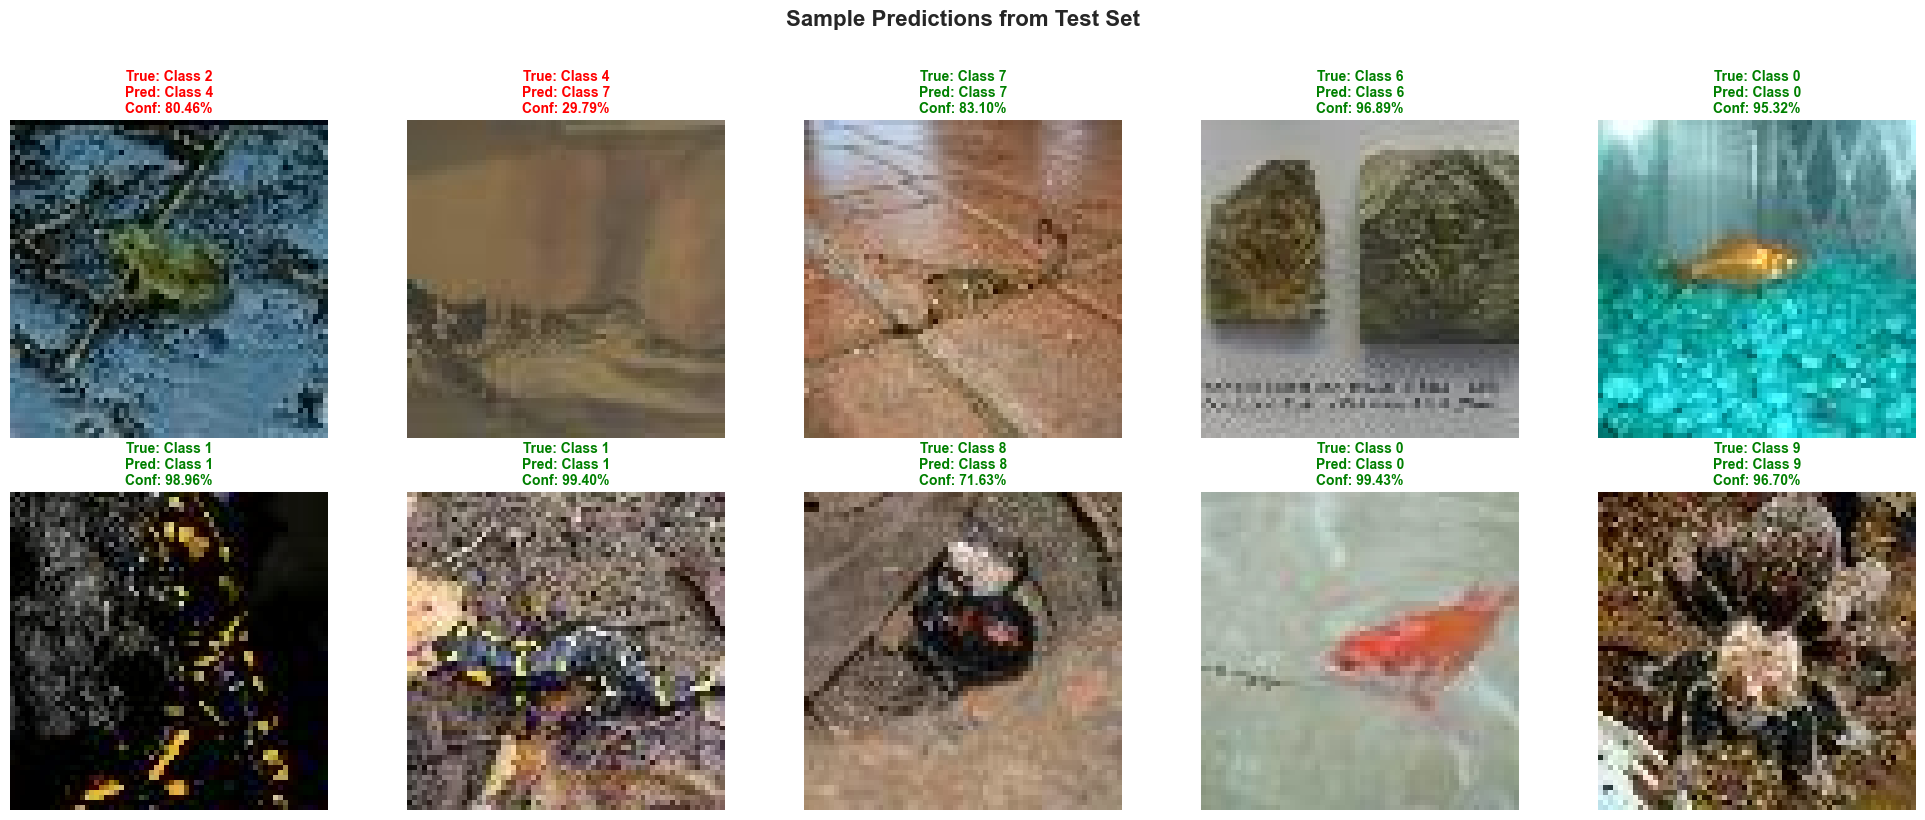

In [24]:
def visualize_predictions(model, dataset, device, num_samples=10, class_names=None):
    model.eval()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]
            
            image_batch = image.unsqueeze(0).to(device)
            output = model(image_batch)
            probabilities = torch.softmax(output, dim=1)
            pred_prob, pred_label = probabilities.max(1)
            
            pred_label = pred_label.item()
            pred_prob = pred_prob.item()
            
            img = image.cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            axes[i].imshow(img)
            axes[i].axis('off')
            
            true_name = class_names[true_label] if class_names else f'Class {true_label}'
            pred_name = class_names[pred_label] if class_names else f'Class {pred_label}'
            
            color = 'green' if pred_label == true_label else 'red'
            title = f'True: {true_name}\nPred: {pred_name}\nConf: {pred_prob:.2%}'
            axes[i].set_title(title, fontsize=10, color=color, fontweight='bold')
    
    plt.suptitle('Sample Predictions from Test Set', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

visualize_predictions(final_model, val_dataset, device, num_samples=10, class_names=class_names)

### 4.4 Сравнительная таблица всех экспериментов

In [25]:
all_results = pd.DataFrame({
    'Stage': [
        'Baseline',
        '3.1-A',
        '3.1-B',
        '3.2-A',
        '3.2-B',
        '3.2-C',
        '3.3-A',
        '3.3-B',
        '3.3-C',
        'Final'
    ],
    'Configuration': [
        '[64,128,256], [2,2,2,2], ReLU',
        '[32,64,128,256], [2,2,2,2], ReLU',
        '[64,128,256], [2,2,2], ReLU',
        f'{best_channels_3_1}, [1,1,1,1], ReLU',
        f'{best_channels_3_1}, [2,2,2,2], ReLU',
        f'{best_channels_3_1}, [3,3,3,3], ReLU',
        f'{best_channels_3_1}, {best_num_blocks_3_2}, ReLU',
        f'{best_channels_3_1}, {best_num_blocks_3_2}, LeakyReLU',
        f'{best_channels_3_1}, {best_num_blocks_3_2}, ELU',
        f'{best_channels_3_1}, {best_num_blocks_3_2}, {best_activation}'
    ],
    'Parameters': [
        f'{count_parameters(baseline_model)}',
        f'{count_parameters(model_3_1_a)}',
        f'{count_parameters(model_3_1_b)}',
        f'{count_parameters(model_3_2_a)}',
        f'{count_parameters(model_3_2_b)}',
        f'{count_parameters(model_3_2_c)}',
        f'{count_parameters(model_3_3_a)}',
        f'{count_parameters(model_3_3_b)}',
        f'{count_parameters(model_3_3_c)}',
        f'{count_parameters(final_model)}'
    ],
    'Best Val Acc (%)': [
        f'{baseline_best_acc:.2f}',
        f'{best_acc_3_1_a:.2f}',
        f'{best_acc_3_1_b:.2f}',
        f'{best_acc_3_2_a:.2f}',
        f'{best_acc_3_2_b:.2f}',
        f'{best_acc_3_2_c:.2f}',
        f'{best_acc_3_3_a:.2f}',
        f'{best_acc_3_3_b:.2f}',
        f'{best_acc_3_3_c:.2f}',
        f'{best_final_acc:.2f}'
    ],
    'Final Train Acc (%)': [
        f'{baseline_history["train_acc"][-1]:.2f}',
        f'{history_3_1_a["train_acc"][-1]:.2f}',
        f'{history_3_1_b["train_acc"][-1]:.2f}',
        f'{history_3_2_a["train_acc"][-1]:.2f}',
        f'{history_3_2_b["train_acc"][-1]:.2f}',
        f'{history_3_2_c["train_acc"][-1]:.2f}',
        f'{history_3_3_a["train_acc"][-1]:.2f}',
        f'{history_3_3_b["train_acc"][-1]:.2f}',
        f'{history_3_3_c["train_acc"][-1]:.2f}',
        f'{final_history["train_acc"][-1]:.2f}'
    ],
    'Overfitting Gap (%)': [
        f'{baseline_history["train_acc"][-1] - baseline_history["val_acc"][-1]:.2f}',
        f'{history_3_1_a["train_acc"][-1] - history_3_1_a["val_acc"][-1]:.2f}',
        f'{history_3_1_b["train_acc"][-1] - history_3_1_b["val_acc"][-1]:.2f}',
        f'{history_3_2_a["train_acc"][-1] - history_3_2_a["val_acc"][-1]:.2f}',
        f'{history_3_2_b["train_acc"][-1] - history_3_2_b["val_acc"][-1]:.2f}',
        f'{history_3_2_c["train_acc"][-1] - history_3_2_c["val_acc"][-1]:.2f}',
        f'{history_3_3_a["train_acc"][-1] - history_3_3_a["val_acc"][-1]:.2f}',
        f'{history_3_3_b["train_acc"][-1] - history_3_3_b["val_acc"][-1]:.2f}',
        f'{history_3_3_c["train_acc"][-1] - history_3_3_c["val_acc"][-1]:.2f}',
        f'{final_history["train_acc"][-1] - final_history["val_acc"][-1]:.2f}'
    ]
})

print('\n', all_results.to_string(index=False))

val_accs = [
    baseline_best_acc, best_acc_3_1_a, best_acc_3_1_b,
    best_acc_3_2_a, best_acc_3_2_b, best_acc_3_2_c,
    best_acc_3_3_a, best_acc_3_3_b, best_acc_3_3_c,
    best_final_acc
]
best_overall_idx = val_accs.index(max(val_accs))
best_overall_stage = all_results.iloc[best_overall_idx]['Stage']

print(f'Лучшая конфигурация: {best_overall_stage}')
print(f'   Val Accuracy: {max(val_accs):.2f}%')
print(f'   Configuration: {all_results.iloc[best_overall_idx]["Configuration"]}')

overfitting_gaps = [
    baseline_history['train_acc'][-1] - baseline_history['val_acc'][-1],
    history_3_1_a['train_acc'][-1] - history_3_1_a['val_acc'][-1],
    history_3_1_b['train_acc'][-1] - history_3_1_b['val_acc'][-1],
    history_3_2_a['train_acc'][-1] - history_3_2_a['val_acc'][-1],
    history_3_2_b['train_acc'][-1] - history_3_2_b['val_acc'][-1],
    history_3_2_c['train_acc'][-1] - history_3_2_c['val_acc'][-1],
    history_3_3_a['train_acc'][-1] - history_3_3_a['val_acc'][-1],
    history_3_3_b['train_acc'][-1] - history_3_3_b['val_acc'][-1],
    history_3_3_c['train_acc'][-1] - history_3_3_c['val_acc'][-1],
    final_history['train_acc'][-1] - final_history['val_acc'][-1]
]

max_gap_idx = overfitting_gaps.index(max(overfitting_gaps))
min_gap_idx = overfitting_gaps.index(min(overfitting_gaps))

print(f'   Наибольшее переобучение: {all_results.iloc[max_gap_idx]["Stage"]} ({overfitting_gaps[max_gap_idx]:.2f}%)')
print(f'   Наименьшее переобучение: {all_results.iloc[min_gap_idx]["Stage"]} ({overfitting_gaps[min_gap_idx]:.2f}%)')

print(f'3. Ключевые выводы:')
print(f'   - Оптимальные каналы: {best_channels_3_1}')
print(f'   - Оптимальное количество блоков: {best_num_blocks_3_2}')
print(f'   - Лучшая функция активации: {best_activation}')
print(f'   - Финальная модель достигла {best_final_acc:.2f}% на validation set')
print(f'   - Test accuracy: {test_acc:.2f}%')
print(f'   - Улучшение от baseline: {best_final_acc - baseline_best_acc:+.2f}%')


    Stage                               Configuration Parameters Best Val Acc (%) Final Train Acc (%) Overfitting Gap (%)
Baseline               [64,128,256], [2,2,2,2], ReLU    2777674            58.60               62.44                3.84
   3.1-A            [32,64,128,256], [2,2,2,2], ReLU    2797610            59.60               64.14               11.34
   3.1-B                 [64,128,256], [2,2,2], ReLU    2777674            51.60               60.24               17.44
   3.2-A         [32, 64, 128, 256], [1,1,1,1], ReLU    1228970            61.40               65.80                4.40
   3.2-B         [32, 64, 128, 256], [2,2,2,2], ReLU    2797610            63.60               68.22                4.62
   3.2-C         [32, 64, 128, 256], [3,3,3,3], ReLU    4366250            59.60               62.34                6.94
   3.3-A      [32, 64, 128, 256], [2, 2, 2, 2], ReLU    2797610            60.60               64.70                4.10
   3.3-B [32, 64, 128, 256], [

## Выводы

### Основные результаты:

1. **Оптимизация каналов (3.1):**
   - Оптимальное количество каналов: [32,64,128,256]. Засчет постепенного, нерезкого увеличения поля модель работает лучше

2. **Оптимизация количества блоков (3.2):**
   - Оптимальное количество блоков: [2, 2, 2, 2]. Меньшее число блоков недообучает модель, большее количество переобучает

3. **Оптимизация функций активации (3.3):**
   - Оптимальная функция активации: ReLU.

4. **Финальная модель:**
   - Финальная модель по сравнению с бейзлайном имеет +8.2% к качеству

5. **Есть ли признаки переобучения (большая разница между train и val)?**
   - Да, в конкретном случае на это сильно влияет количество каналов и функция активации